In [1]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtree

import numpy as np
import optax
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from dln import (
    create_dln_model, 
    create_minibatches, 
    true_dln_learning_coefficient, 
    mse_loss, 
)
from mcmc_utils import (
    MCMCConfig,
    run_mcmc,
    rlct_estimate_regression,
    linspaced_itemps_by_n
)
import numpyro
import numpyro.distributions as dist

from utils import to_json_friendly_tree, running_mean
from sklearn.manifold import TSNE

def tsne_metric(x, y):
    return jnp.linalg.norm(x - y, ord=2)


def generate_correlation_matrix(key, n):
    """
    Generate a random positive definite symmetric square matrix.
    
    :param key: JAX random key
    :param n: The size of the matrix (n x n)
    :return: A random positive definite symmetric square matrix
    """
    key, subkey = jax.random.split(key)
    A = jax.random.uniform(subkey, (n, n))
    B = jnp.dot(A, A.T)
    C = B / jnp.max(jnp.abs(B))  # Normalize to ensure diagonal elements are 1
    return (C + C.T) / 2  # Ensure perfect symmetry

@jax.jit
def tree_l2_dist(tree1, tree2):
    return jnp.sqrt(jnp.sum(jnp.stack(jtree.tree_flatten(jtree.tree_map(lambda x, y: jnp.sum((x - y) ** 2), tree1, tree2))[0])))


def build_mcmc_model(
        forward_fn, 
        sample_param_tree, 
        prior_config=None, 
        sigma_obs=1.0
    ):
    prior_loc = prior_config["loc"]
    prior_scale = prior_config["scale"]

    def mcmc_model(X, itemp=1.0):
        flatten_param, tree_def = jtree.tree_flatten(sample_param_tree)
        param = [
            numpyro.sample(
                i, 
                dist.Normal(prior_loc, prior_scale), 
                sample_shape=x.shape
            )
            for i, x in enumerate(flatten_param)
        ]
        param = jtree.tree_unflatten(tree_def, param)
        x, y = X
        mu = forward_fn(param, x)
        numpyro.sample("y", dist.Normal(mu, sigma_obs / jnp.sqrt(itemp)), obs=y)
        return 
    
    return mcmc_model

def collapse_first_two_dims(param):
    shape = param.shape
    new_shape = (shape[0] * shape[1],) + shape[2:]
    return param.reshape(new_shape)

def _extract_chain(samples, chain_id):
    return jtree.tree_map(lambda x: x[chain_id], samples)




In [2]:
expt_name = None

dln_config = dict(
    input_dim = 3,
    output_dim = 3,
    hidden_layer_widths = [3],
    initialisation_exponent = 1.5, 
    teacher_matrix = None,
)
mcmc_config = {
    'num_posterior_samples': 80003,
    'thinning': 5,
    'num_warmup': 2000,
    'num_chains': 1,
}

data_config = {
    "num_training_data": 20,
    "num_test_data": 5000,
    "feature_map": None, # None, ("polynomial", d)
    "output_noise_std": 0.1, 
    "input_noise_std": 1.0,
    "teacher_matrix": "random", # diagonal, "sparse", 
    "sparsity": None, 
    "idcorr": True,
}
loss_trace_minibatch = True # if True loss_trace uses minibatch, else use full dataset. 


itemp = 1 / np.log(data_config["num_training_data"])
num_itemps = 5
training_config = {
    "optim": "sgd", 
    "learning_rate": 1e-4, 
    "momentum": None, 
    "batch_size": 128, 
    "num_steps": 20000
}
seed = 42
logging_period = 50
verbose = True
do_plot = False





# seeding
np.random.seed(seed)
rngkey = jax.random.PRNGKey(seed)

####################
# Initialisations
####################
# create DLN model
input_dim = dln_config["input_dim"]
output_dim = dln_config["output_dim"]
hidden_layer_widths = dln_config["hidden_layer_widths"]
layer_widths = hidden_layer_widths + [output_dim]
initialisation_exponent = dln_config["initialisation_exponent"]
if dln_config["teacher_matrix"] is None:
    teacher_matrix = np.diag(np.linspace(1, 0.2, input_dim))
elif type(dln_config["teacher_matrix"]) == list:
    if len(dln_config["teacher_matrix"]) == 3:
        exponent, scale, start = dln_config["teacher_matrix"]
        # produce a matrix with the ith eigenvalue is given by scale / (start + i) ** exponent
        teacher_matrix = np.diag(scale / (start + np.arange(input_dim)) ** exponent)
    elif len(dln_config["teacher_matrix"]) == input_dim:
        teacher_matrix = np.diag(dln_config["teacher_matrix"])
    else:
        raise ValueError("Invalid teacher matrix specification")
else:
    raise ValueError("Invalid teacher matrix specification")
teacher_matrix = teacher_matrix[:output_dim, :input_dim] * 0.0


# DLN model
initialisation_sigma = np.sqrt(input_dim ** (-initialisation_exponent))
model = create_dln_model(layer_widths, sigma=initialisation_sigma)
loss_fn = jax.jit(lambda param, inputs, targets: mse_loss(param, model, inputs, targets))

rngkey, subkey = jax.random.split(rngkey)
param_init = model.init(rngkey, jnp.zeros((1, input_dim)))
tree_def = jtree.tree_structure(param_init)
total_num_param = np.sum([np.prod(p.shape) for p in jtree.tree_flatten(param_init)[0]])
print(jtree.tree_map(lambda x: x.shape, param_init))
print(f"Total number of parameters: {total_num_param}")


# create training data
num_training_data = data_config["num_training_data"]
num_test_data = data_config["num_test_data"]
use_idcorr = data_config["idcorr"]
output_noise_std = data_config["output_noise_std"]
initialisation_exponent = dln_config["initialisation_exponent"]


rngkey, rngkey = jax.random.split(rngkey)
if use_idcorr:
    feature_corr = np.eye(input_dim)
else:
    feature_corr = generate_correlation_matrix(rngkey, input_dim)
x_train = jax.random.multivariate_normal(
    rngkey, 
    jnp.zeros(input_dim), 
    feature_corr, 
    shape=(num_training_data,), 
    dtype=jnp.float32
)

rngkey, subkey = jax.random.split(rngkey)
y_train = (
    x_train @ teacher_matrix 
    + jax.random.normal(
        rngkey, 
        shape=(num_training_data, output_dim)) * output_noise_std
)

####################################################
# Run MCMC
####################################################
mcmc_config = MCMCConfig(
    num_posterior_samples=mcmc_config["num_posterior_samples"],
    thinning=mcmc_config["thinning"],
    num_warmup=mcmc_config["num_warmup"],
    num_chains=mcmc_config["num_chains"],
)

# itemps = list(linspaced_itemps_by_n(num_training_data, num_itemps))
itemps = [0.005, 0.007, 0.01, 0.015, 0.02, 
          0.025, 0.03, 0.04, 0.05, 0.08, 
          0.1, 0.5, 1.0, 1.5]
record = []
for i, itemp in enumerate(itemps):
    print(f"Running MCMC for ({i + 1}) itemp={itemp}")

    mcmc_model = build_mcmc_model(
        model.apply,
        param_init,
        prior_config={"loc": 0.0, "scale": 5.0},
        sigma_obs=output_noise_std,
    )
    rngkey, subkey = jax.random.split(rngkey)
    mcmc = run_mcmc(
        mcmc_model,
        (x_train, y_train),
        rngkey,
        mcmc_config,
        init_params=None,
        itemp=itemp,
        progress_bar=True,
    )
    posterior_samples = mcmc.get_samples(group_by_chain=True)
    posterior_samples = jtree.tree_unflatten(tree_def, [posterior_samples[key] for key in posterior_samples.keys()])
    num_thin_posterior_samples_per_chain = jtree.tree_flatten(posterior_samples)[0][0].shape[1]
    rec = {
        "itemp": itemp,
        "posterior_samples": posterior_samples,
        "num_thin_posterior_samples_per_chain": num_thin_posterior_samples_per_chain
    }
    record.append(rec)

print(jtree.tree_map(lambda x: x.shape, posterior_samples))

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


{'deep_linear_network/linear': {'w': (3, 3)}, 'deep_linear_network/linear_1': {'w': (3, 3)}}
Total number of parameters: 18


INFO:__main__:Running MCMC


Running MCMC for (1) itemp=0.005


sample: 100%|██████████| 82003/82003 [00:43<00:00, 1869.28it/s, 255 steps of size 1.40e-02. acc. prob=0.83] 
INFO:__main__:Running MCMC


Running MCMC for (2) itemp=0.007


sample: 100%|██████████| 82003/82003 [00:50<00:00, 1638.57it/s, 255 steps of size 1.15e-02. acc. prob=0.84] 
INFO:__main__:Running MCMC


Running MCMC for (3) itemp=0.01


sample: 100%|██████████| 82003/82003 [01:03<00:00, 1295.66it/s, 511 steps of size 9.05e-03. acc. prob=0.88] 
INFO:__main__:Running MCMC


Running MCMC for (4) itemp=0.015


sample: 100%|██████████| 82003/82003 [01:20<00:00, 1013.35it/s, 511 steps of size 6.86e-03. acc. prob=0.89] 
INFO:__main__:Running MCMC


Running MCMC for (5) itemp=0.02


sample: 100%|██████████| 82003/82003 [01:16<00:00, 1073.04it/s, 255 steps of size 6.89e-03. acc. prob=0.84] 
INFO:__main__:Running MCMC


Running MCMC for (6) itemp=0.025


sample: 100%|██████████| 82003/82003 [01:15<00:00, 1079.03it/s, 1023 steps of size 6.84e-03. acc. prob=0.80]
INFO:__main__:Running MCMC


Running MCMC for (7) itemp=0.03


sample: 100%|██████████| 82003/82003 [01:39<00:00, 824.49it/s, 511 steps of size 5.09e-03. acc. prob=0.88] 
INFO:__main__:Running MCMC


Running MCMC for (8) itemp=0.04


sample: 100%|██████████| 82003/82003 [01:33<00:00, 879.97it/s, 1023 steps of size 5.08e-03. acc. prob=0.82] 
INFO:__main__:Running MCMC


Running MCMC for (9) itemp=0.05


sample: 100%|██████████| 82003/82003 [01:46<00:00, 768.09it/s, 1023 steps of size 4.18e-03. acc. prob=0.87]
INFO:__main__:Running MCMC


Running MCMC for (10) itemp=0.08


sample: 100%|██████████| 82003/82003 [02:54<00:00, 470.82it/s, 1023 steps of size 2.47e-03. acc. prob=0.93]
INFO:__main__:Running MCMC


Running MCMC for (11) itemp=0.1


sample: 100%|██████████| 82003/82003 [01:45<00:00, 779.92it/s, 1023 steps of size 3.66e-03. acc. prob=0.78]
INFO:__main__:Running MCMC


Running MCMC for (12) itemp=0.5


sample: 100%|██████████| 82003/82003 [02:32<00:00, 537.32it/s, 1023 steps of size 1.63e-03. acc. prob=0.83]
INFO:__main__:Running MCMC


Running MCMC for (13) itemp=1.0


sample: 100%|██████████| 82003/82003 [01:56<00:00, 702.97it/s, 1023 steps of size 5.44e-04. acc. prob=0.95]
INFO:__main__:Running MCMC


Running MCMC for (14) itemp=1.5


sample: 100%|██████████| 82003/82003 [01:55<00:00, 710.68it/s, 1023 steps of size 5.47e-04. acc. prob=0.94]


{'deep_linear_network/linear': {'w': (1, 16000, 3, 3)}, 'deep_linear_network/linear_1': {'w': (1, 16000, 3, 3)}}


Plotting chain 0, itemp=0.005
Plotting chain 0, itemp=0.007
Plotting chain 0, itemp=0.010
Plotting chain 0, itemp=0.015
Plotting chain 0, itemp=0.020
Plotting chain 0, itemp=0.025
Plotting chain 0, itemp=0.030
Plotting chain 0, itemp=0.040
Plotting chain 0, itemp=0.050
Plotting chain 0, itemp=0.080
Plotting chain 0, itemp=0.100
Plotting chain 0, itemp=0.500
Plotting chain 0, itemp=1.000
Plotting chain 0, itemp=1.500


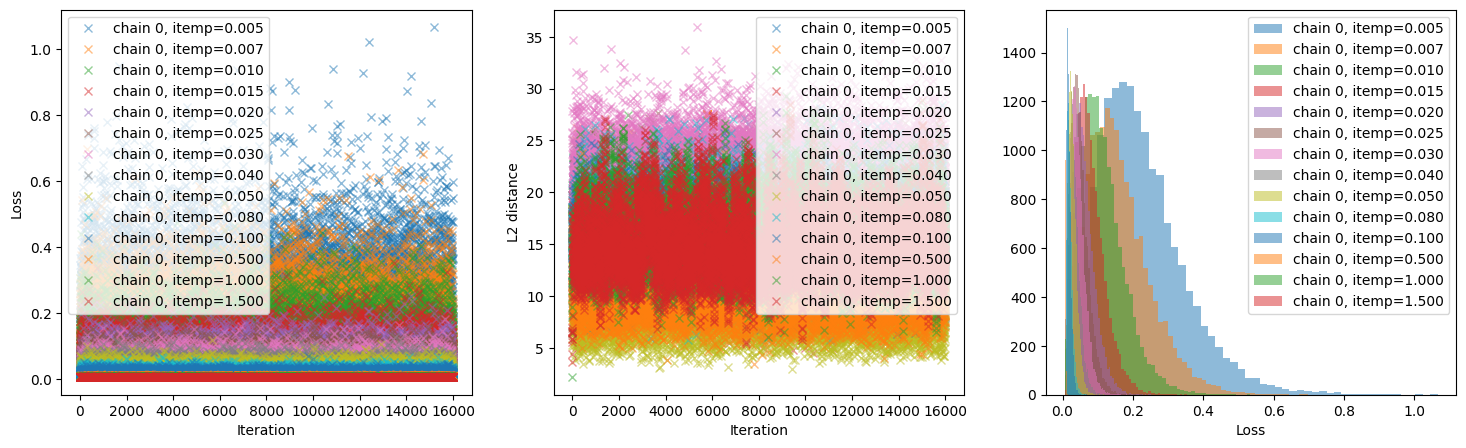

In [3]:
vmap_loss_fn = jax.vmap(loss_fn, in_axes=(jtree.tree_map(lambda x: 0, tree_def), None, None))
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
ax = axes[0]
ax1 = axes[1]
ax2 = axes[2]


for rec in record:
    itemp = rec["itemp"]
    posterior_samples = rec["posterior_samples"]
    num_thin_posterior_samples_per_chain = rec["num_thin_posterior_samples_per_chain"]
    distance_rec = []
    loss_trace_rec = []
    for c in range(mcmc_config.num_chains):
        label = f"chain {c}, itemp={itemp:.3f}"
        print(f"Plotting {label}")
        chain_samples = _extract_chain(posterior_samples, c)
        loss_trace = vmap_loss_fn(chain_samples, x_train, y_train).flatten()
        if loss_trace[0] > 10:
            continue
        ax.plot(loss_trace, "x", alpha=0.5, label=label)

        init_tree = jtree.tree_map(lambda x: x[0], chain_samples)
        distances = [
            tree_l2_dist(init_tree, jtree.tree_map(lambda x: x[i], chain_samples))
            for i in range(1, num_thin_posterior_samples_per_chain)
        ]
        ax1.plot(distances, "x", alpha=0.5, label=label)
        ax2.hist(loss_trace, bins=50, alpha=0.5, label=label)
        distance_rec.append(distances)
        loss_trace_rec.append(loss_trace)
    rec["loss_trace"] = np.array(loss_trace_rec)
    rec["distances"] = np.array(distance_rec)

ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")

ax1.legend()
ax1.set_xlabel("Iteration")
ax1.set_ylabel("L2 distance")

ax2.set_xlabel("Loss")
ax2.legend()

Text(0.5, 0, 'Sorted index')

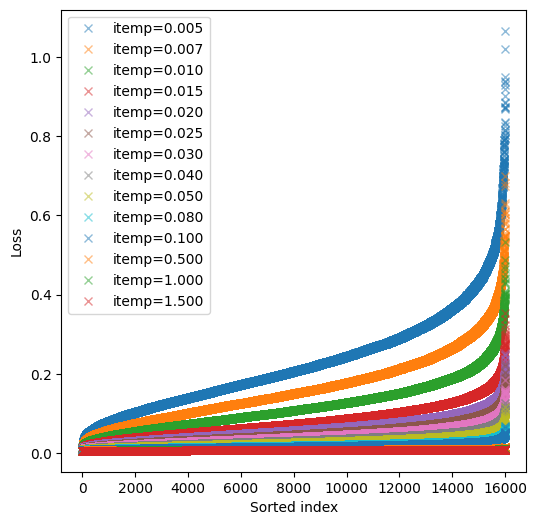

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for rec in record:
    loss_traces = rec["loss_trace"]
    loss_trace = loss_traces[0, :]
    loss_trace.sort()
    if loss_trace[0] > 10:
        continue
    ax.plot(loss_trace, "x", alpha=0.5, label=f"itemp={rec['itemp']:.3f}")
ax.legend()
ax.set_ylabel("Loss")
ax.set_xlabel("Sorted index")

In [5]:
def make_potential_fn(
        teacher_matrix, 
        feature_corr, 
        feature_output_cross_correlation, 
        layer_widths
    ):
    eigvals, eigvecs = np.linalg.eigh(feature_corr)
    ChangeOfBasis = eigvecs @ np.diag(eigvals ** (-1/2)) @ eigvecs.T
    modified_feature_output_cross_correlation = feature_output_cross_correlation @ ChangeOfBasis 
    U, S, V = np.linalg.svd(modified_feature_output_cross_correlation)
    V = V.T
    Vhat = np.linalg.inv(ChangeOfBasis) @ V
    def get_matrices():
        return U, S, V, Vhat, ChangeOfBasis

    def potential_matrix_fn(param):
        total_matrix = jnp.linalg.multi_dot(
            [
                jnp.array(param[f'deep_linear_network/linear{loc}']['w']) 
                for loc in [''] + [f'_{i}' for i in range(1, len(layer_widths))]
            ]
        )
        potential_matrix = U.T @ (total_matrix.T - teacher_matrix) @ Vhat
        return potential_matrix
    
    def potential_fn(param):
        potential_matrix = potential_matrix_fn(param)
        return jnp.sum(potential_matrix ** 2)
    return potential_matrix_fn, potential_fn, get_matrices


feature_output_cross_correlation = teacher_matrix @ feature_corr
potential_matrix_fn, potential_fn, get_matrices = make_potential_fn(
    teacher_matrix, 
    feature_corr, 
    feature_output_cross_correlation, 
    layer_widths=layer_widths
)

U, S, V, Vhat, ChangeOfBasis = get_matrices()

Text(0.5, 1.0, 'Norm of corrected total matrices')

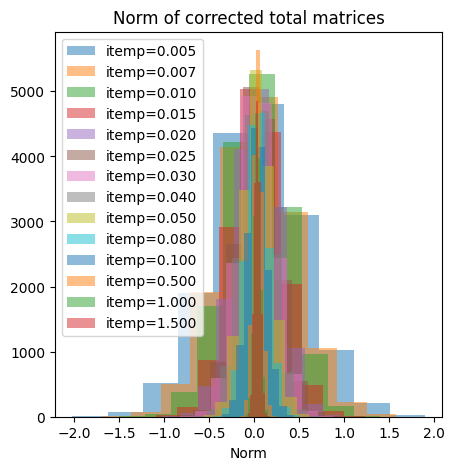

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
teacher_norm = np.linalg.svd(teacher_matrix, compute_uv=False).sum()
for rec in record: 
    loss_trace = rec["loss_trace"]
    if loss_trace[0, 0] > 10:
        continue
    posterior_samples = rec["posterior_samples"]
    num_thin_posterior_samples_per_chain = rec["num_thin_posterior_samples_per_chain"]
    chain_samples = _extract_chain(posterior_samples, 0)
    corrected_total_matrices = [
        U.T @ jnp.linalg.multi_dot(
            jtree.tree_flatten(jtree.tree_map(lambda x: x[i], chain_samples))[0]
        ).T @ Vhat
        for i in range(num_thin_posterior_samples_per_chain)
    ]
    threshold = .1
    norms = [
        jnp.trace(m) for m in corrected_total_matrices
    ]
    ax.hist(norms, alpha=0.5, label=f"itemp={rec['itemp']:.3f}")

ax.legend()
ax.set_xlabel("Norm")
ax.set_title("Norm of corrected total matrices")

In [9]:
true_singular_values = np.linalg.svd(teacher_matrix, compute_uv=False)
threshold = 0.05
further_thin = 10
for rec in record: 
    loss_trace = rec["loss_trace"]
    if loss_trace[0, 0] > 10:
        continue
    posterior_samples = rec["posterior_samples"]
    num_thin_posterior_samples_per_chain = rec["num_thin_posterior_samples_per_chain"]
    all_samples = jtree.tree_map(collapse_first_two_dims, posterior_samples)
    corrected_total_matrices = [
        U.T @ jnp.linalg.multi_dot(
            jtree.tree_flatten(jtree.tree_map(lambda x: x[i], all_samples))[0]
        ).T @ Vhat
        for i in range(num_thin_posterior_samples_per_chain)
    ]
    ranks = [
        np.sum(np.diag(m) > threshold) for m in corrected_total_matrices
    ]
    norms = [
        np.linalg.svd(m, compute_uv=False).sum() for m in corrected_total_matrices
    ]

    rec["corrected_total_matrices"] = corrected_total_matrices
    rec["ranks"] = np.array(ranks)
    rec["norms"] = np.array(norms)


    # fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # ax = axes[0]
    # ax.hist(ranks, alpha=0.5, label=f"itemp={rec['itemp']:.3f}")
    # ax.set_title(f"itemp={rec['itemp']:.3f}")

    # ax = axes[1]
    # vecs = np.array([m.flatten() for m in corrected_total_matrices[::further_thin]])
    # tsne = TSNE(n_components=2, metric=tsne_metric)
    # vecs_2d = tsne.fit_transform(vecs)
    # ranks = ranks[::further_thin]
    # for i, r in enumerate(sorted(set(ranks), reverse=True)):
    #     ax.plot(vecs_2d[ranks == r, 0], vecs_2d[ranks == r, 1], "x", label=f"rank={r}")
    # ax.legend()
    
    

Text(0.5, 0.98, 'Diagonal of posterior samples vs true singular values\n[0.0, 0.0, 0.0]')

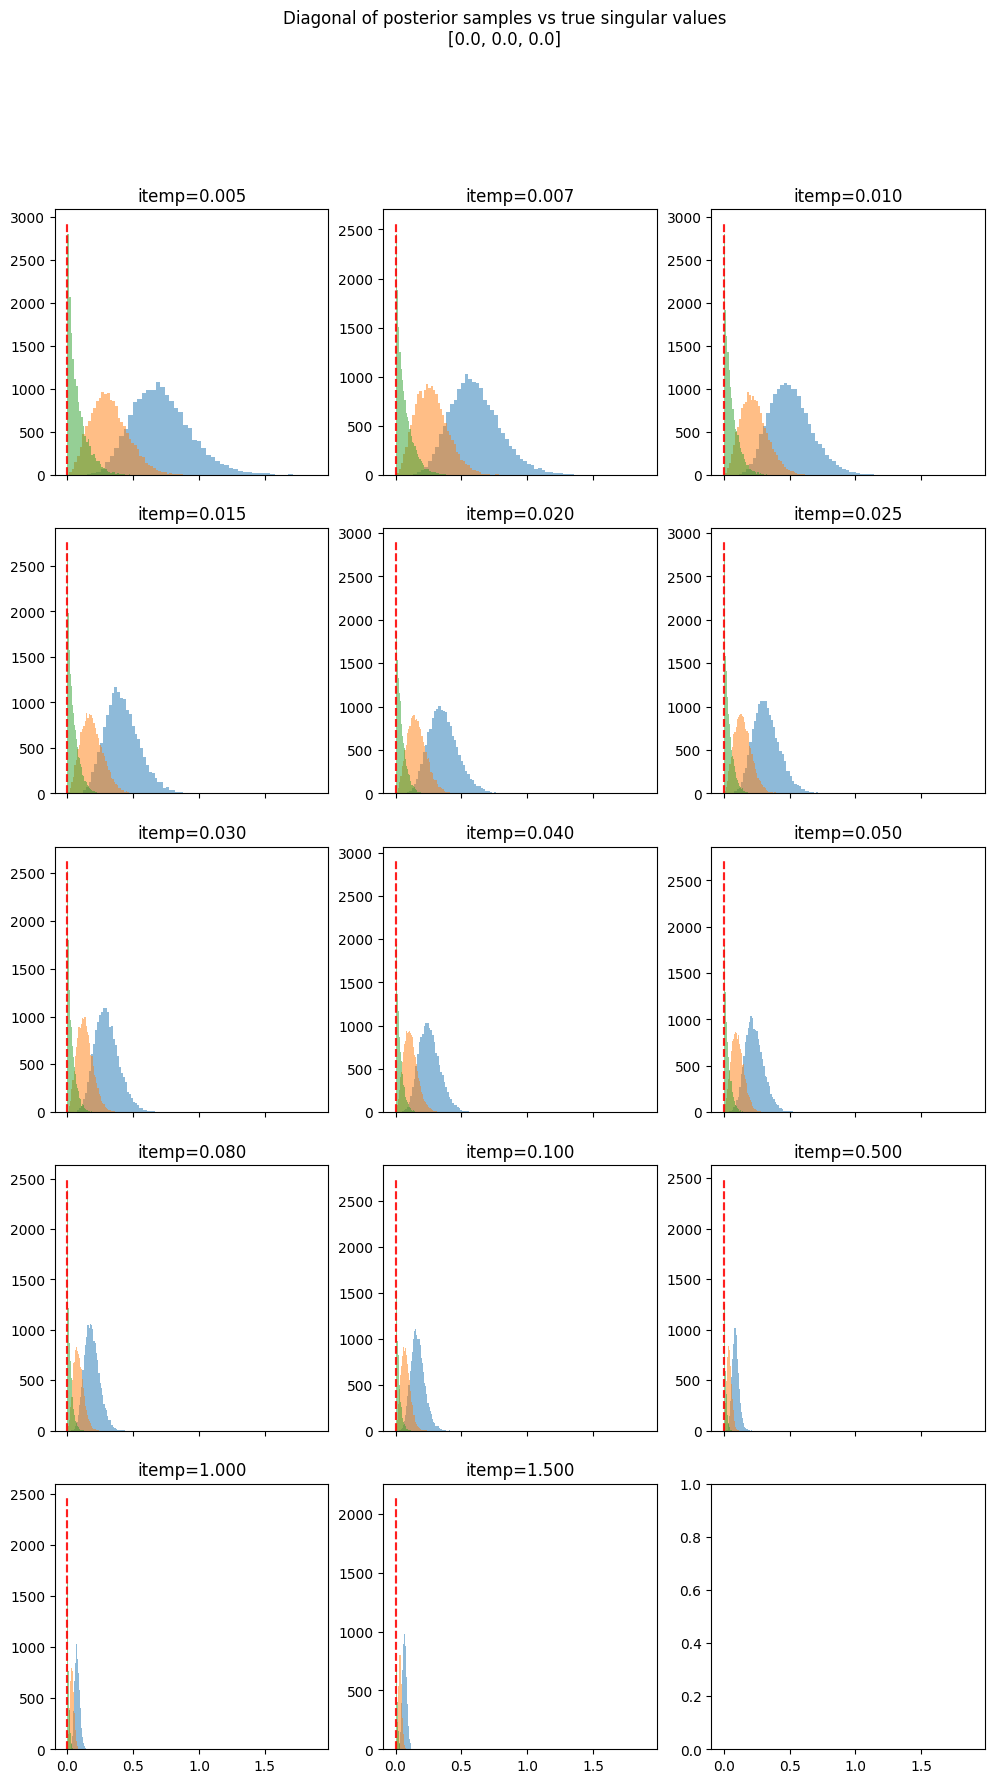

In [12]:
num_plots = len(record)
num_cols = 3
num_rows = num_plots // num_cols + (num_plots % num_cols > 0)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows), sharex=True)
axes = axes.flatten()
for i, rec in enumerate(record):
    loss_trace = rec["loss_trace"]
    itemp = rec["itemp"]
    if loss_trace[0, 0] > 10:
        continue
    corrected_total_matrices = rec["corrected_total_matrices"]
    # diags = np.array([np.diag(m) for m in corrected_total_matrices])
    diags = np.array([np.linalg.svd(m, compute_uv=False) for m in corrected_total_matrices])
    ax = axes[i]
    for j in range(diags.shape[1]):
        ax.hist(diags[:, j], alpha=0.5, bins=50, label=f"itemp={itemp:.3f}")
    ymin, ymax = ax.get_ylim()
    ax.vlines(true_singular_values, ymin, ymax, color="red", alpha=0.5, label="True singular values", linestyles="--")
    ax.set_title(f"itemp={itemp:.3f}")

fig.suptitle(f"Diagonal of posterior samples vs true singular values\n{(true_singular_values.tolist())}")

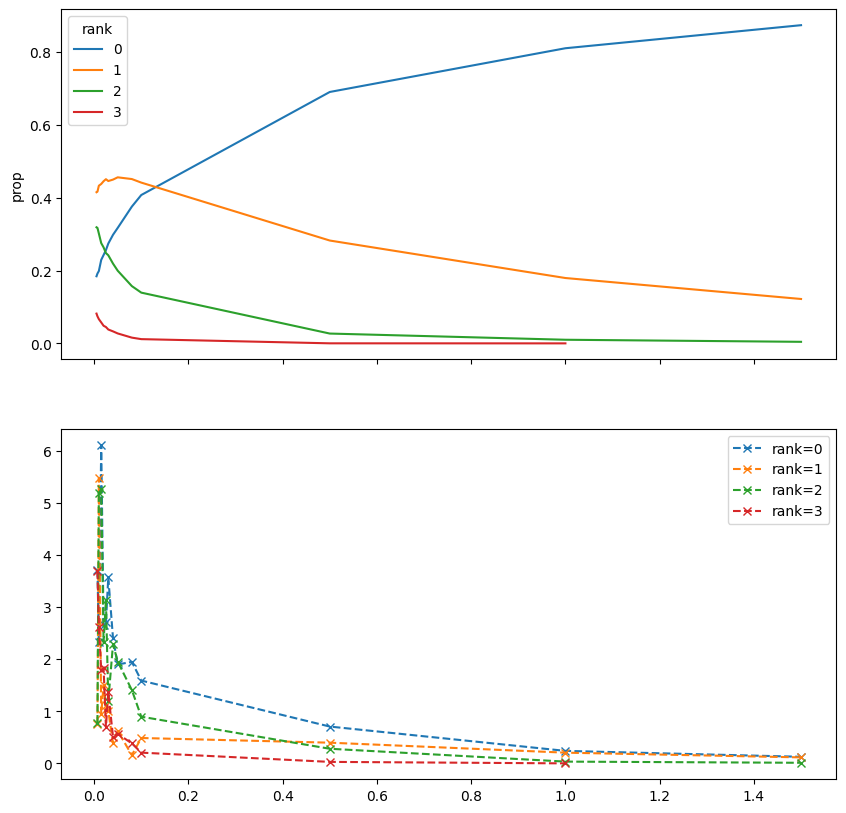

In [13]:
data = []
for rec in record:
    itemp = rec["itemp"]
    ranks = rec["ranks"]
    for i, r in enumerate(sorted(set(ranks), reverse=True)):
        data.append({
            "itemp": itemp,
            "rank": r,
            "count": np.sum(ranks == r)
        })
df_rank = pd.DataFrame(data)
df = df_rank
df["prop"] = df["count"] / df.groupby("itemp")["count"].transform("sum").mean()
# df = df[df["itemp"] <= 0.5]
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
ax = axes[0]
sns.lineplot(
    data=df,
    x="itemp", 
    y="prop",  
    hue="rank",
    err_style="bars",
    err_kws={"capsize": 5, "elinewidth": 1, "capthick": 1},
    ax=ax, 
    palette="tab10", 
)
# ax.set_xscale("log")

ax = axes[1]
df = df.pivot(index="itemp", columns="rank", values="prop")
for k in sorted(set(df.columns)):
    props = df[k]
    itemps = np.array(props.index)
    rate = np.diff(props.values) / np.diff(itemps)
    rate = np.abs(rate)
    ax.plot(itemps[1:], rate, "x--", label=f"rank={k}")
ax.legend()
# ax.set_xscale("log")

In [1]:
df = df_rank
df = df.pivot(index="itemp", columns="rank", values="count")
df.fillna(0, inplace=True)
df = df.div(df.sum(axis=1), axis=0)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
df.plot(kind="bar", stacked=True, ax=ax)
df

NameError: name 'df_rank' is not defined

In [ ]:
# - [ ] Plot distribution of the norm of the jacobian and see if posterior samples concentrate near critical points. 
# - [ ] MCMC for the non-realisable case. Simon says that there are the O(sqrt(n)) case. Need to ensure the true distribution has repeated singular values. Eckart-Young-Miinsky theorem give the set of minimiser of the l2 loss in terms of the true singular values. 
